In [1]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy        
import statsmodels


from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 999

sns.set()

plt.rcParams["figure.figsize"] = (10,7)

In [2]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sigmod_src.utils import read_json, pprint_json, path_from_spec_id, get_vector_for_spec_id
from sigmod_src.data.embedding import Embedder

# Load data

In [5]:
LABELS_PATH = '../data/raw/sigmod_medium_labelled_dataset.csv'

In [6]:
labels_df = pd.read_csv(LABELS_PATH)
labels_df.shape

(46665, 3)

In [7]:
labels_df.head()

,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


# Load specs df

In [8]:
specs_df = pd.read_csv('../data/processed/specs_preprocessed.csv')
specs_df.index=  specs_df.spec_id
specs_df.shape

(29771, 5)

In [9]:
specs_df[specs_df.page_title.isnull()]

,spec_id,page_title,page_title_stem,brand,site
spec_id,,,,,


In [10]:
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site
spec_id,,,,,
www.ebay.com//57656,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp,canon,www.ebay.com
www.ebay.com//60583,www.ebay.com//60583,canon rebel 2000 35 mm great condition case,canon rebel 2000 35 mm great condit case,canon,www.ebay.com
www.ebay.com//60440,www.ebay.com//60440,canon eos rebel t3i 18 55mm,canon eo rebel t3i 18 55mm,canon,www.ebay.com
www.ebay.com//24139,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2,ge c1033 10 1 mp 3x zoom 2,ge,www.ebay.com
www.ebay.com//54903,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp,vivitar,www.ebay.com


In [11]:
specs_df.page_title.sample(5).values[0]

'sony cybershot dsc w830 india bangalore'

In [12]:
specs_df.page_title_stem.sample(5).values[0]

'soni alpha zealand price'

# Make embedder and index

In [33]:
emb = Embedder.load('../models/embedder')

/home/boris/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [34]:
# emb = Embedder(vector_size=200,
#                train_epochs=100,
#                index_trees=1000)

In [35]:
# emb.fit(specs_df.page_title_stem, specs_df.spec_id)

# Visual evaluation

In [36]:
random_spec = specs_df.sample(1).iloc[0]
spec_id = random_spec.spec_id
text = random_spec.page_title_stem

nn_ids = emb.lookup_ids(text, n=100)
nn_texts =  emb.lookup_texts(text, n=100)

print(f'Query:\n\t{text}')
newline_ = '\n\t'
print(f'3 Closest:\n\t{newline_.join(nn_texts[:3])}')

print(f'Most distant:\n\t{nn_texts[-1]}')

Query:
	soni point shoot
3 Closest:
	soni point shoot
	soni point shoot
	soni point shoot
Most distant:
	fujifilm av100 12mp point shoot


# Obtian labelled dataset recall

In [37]:
def get_candidate_specs(query_text, emb, n):
    nn_spec_ids = emb.lookup_ids(query_text, n=n)
    return nn_spec_ids

dups_df = labels_df[labels_df.label==1]
results = []
print(int(0.5*len(dups_df)))
for row in tqdm(dups_df.sample(int(0.5*len(dups_df))).itertuples()):
    left_spec = specs_df.loc[row.left_spec_id]
    candidates = emb.lookup_ids(left_spec.page_title, n=500)
    target_index = None
    if row.right_spec_id in candidates:
        target_index = list(candidates).index(row.right_spec_id)
    
    
    results.append((row.left_spec_id, row.right_spec_id, target_index))

1791


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [38]:
results_df = pd.DataFrame(results)
results_df.columns = ['left_spec_id', 'right_spec_id', 'right_spec_rank']
results_df.head()

,left_spec_id,right_spec_id,right_spec_rank
0,www.priceme.co.nz//1746,www.ebay.com//55935,NaN
1,www.walmart.com//644,www.ebay.com//53179,146.0
2,www.shopbot.com.au//260,www.ebay.com//54403,159.0
3,www.ebay.com//55277,www.ebay.com//45074,409.0
4,www.ebay.com//55768,www.eglobalcentral.co.uk//135,245.0


In [39]:
def compute_recall_k(ranks, k):
    total_number = len(ranks)
    matched_number = ranks[(~ranks.isnull()) & (ranks <= k)]
    return len(matched_number)/total_number

In [40]:
ks = [1, 10, 50, 100, 500, 1000]
for k in ks:
    print(f'Recall-{k}: ', round(compute_recall_k(results_df.right_spec_rank, k), 4))

Recall-1:  0.0022
Recall-10:  0.0313
Recall-50:  0.1189
Recall-100:  0.22
Recall-500:  0.5617
Recall-1000:  0.5617


# Visualize embedding

## Obtain classes from labels

Each class - camera model. All specs that are duplicates of eachother consitute the same class. In a graph one class = one connected component.

In [41]:
dup_df = labels_df[labels_df.label==1][['left_spec_id', 'right_spec_id', 'label']].sort_values(by=['left_spec_id', 'right_spec_id'])

In [42]:
dup_df.shape

(3582, 3)

In [43]:
dup_df.head()

,left_spec_id,right_spec_id,label
27484,buy.net//5641,www.ebay.com//58588,1
24490,buy.net//5641,www.gosale.com//849,1
12459,buy.net//5641,www.price-hunt.com//9794,1
5120,buy.net//5698,cammarkt.com//501,1
31627,buy.net//5698,www.ebay.com//41940,1


In [44]:
len(set(dup_df.left_spec_id).union(dup_df.right_spec_id))

306

In [45]:
class_mapping = {
    
}

def replace_class_mapping(prev_class, new_class):
    for k in class_mapping:
        if k == prev_class:
            class_mapping[k] = new_class

cur_class = 0
for row in dup_df.itertuples():
    if row.left_spec_id in class_mapping or row.right_spec_id in class_mapping:
        if row.left_spec_id in class_mapping and row.right_spec_id in class_mapping and class_mapping[row.left_spec_id] != class_mapping[row.right_spec_id]:
            raise Exception('wtf')
        
        existing_class = class_mapping.get(row.left_spec_id, class_mapping.get(row.right_spec_id))
        class_mapping[row.left_spec_id] = existing_class
        class_mapping[row.right_spec_id] = existing_class
    else:
        class_mapping[row.left_spec_id] = cur_class
        class_mapping[row.right_spec_id] = cur_class
        cur_class += 1


In [46]:
classes_df = pd.DataFrame({'spec_id': list(class_mapping.keys()), 'class_': list(class_mapping.values())})
classes_df.shape

(306, 2)

In [47]:
classes_df.head()

,spec_id,class_
0,buy.net//5641,0
1,www.ebay.com//58588,0
2,www.gosale.com//849,0
3,www.price-hunt.com//9794,0
4,buy.net//5698,1


In [48]:
classes_df.tail()

,spec_id,class_
301,www.gosale.com//462,25
302,www.shopbot.com.au//271,21
303,www.shopmania.in//1458,26
304,www.mypriceindia.com//52,26
305,www.wexphotographic.com//601,13


In [49]:
classes_df.index = classes_df.spec_id

In [50]:
classes_df.to_csv('../data/interim/classes.csv', index=None)

In [51]:
len(set(labels_df.left_spec_id).union(labels_df.right_spec_id))

306

## Get spec vectors

In [58]:
dir(emb.indexer)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'add_item',
 'build',
 'f',
 'get_distance',
 'get_item_vector',
 'get_n_items',
 'get_n_trees',
 'get_nns_by_item',
 'get_nns_by_vector',
 'load',
 'on_disk_build',
 'save',
 'set_seed',
 'unbuild',
 'unload',
 'verbose']

In [59]:
vecs = []
for i in tqdm(range(len(specs_df))):
    vecs.append(emb.indexer.get_item_vector(i))

HBox(children=(IntProgress(value=0, max=29771), HTML(value='')))

In [61]:
vecs = np.array(vecs)

In [62]:
vecs.shape

(29771, 200)

In [63]:
vecs = pd.DataFrame(vecs, index=specs_df.spec_id)
vecs.shape

(29771, 200)

## Pairwise distances distirubtion

In [64]:
from scipy.spatial.distance import pdist, cdist

In [65]:
sample_features = vecs.sample(5000)

In [66]:
pairwise_distances = pdist(sample_features)

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


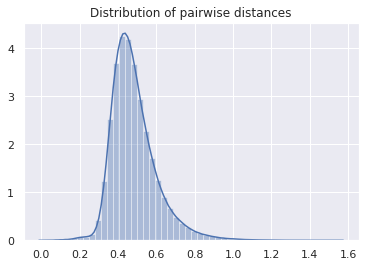

In [67]:
plt.figure()
plt.title('Distribution of pairwise distances')
sns.distplot(pairwise_distances)
plt.show()

In [68]:
# Vector for spec
vecs.loc['www.ebay.com//42835'].head()

0   -0.010493
1   -0.026637
2    0.008443
3   -0.043748
4   -0.091071
Name: www.ebay.com//42835, dtype: float64

In [69]:
duplicate_pairs = dup_df.sample(1000)[['left_spec_id', 'right_spec_id']].values

duplicate_vector_pairs = []
for s1, s2 in duplicate_pairs:
    duplicate_vector_pairs.append([
        vecs.loc[s1],
        vecs.loc[s2]
    ])
    
duplicate_vector_pairs = np.array(duplicate_vector_pairs)

duplicate_vector_pairs[:3]

array([[[-0.06820726, -0.10692831, -0.05537497, ..., -0.0193214 ,
          0.09818213, -0.03311641],
        [-0.09340847, -0.09885562, -0.04172768, ..., -0.0466862 ,
          0.12060856, -0.03512322]],

       [[-0.06437884, -0.10738562, -0.00302583, ..., -0.03987782,
          0.11475271, -0.08153267],
        [-0.05821228, -0.08141793, -0.04220601, ..., -0.04944737,
          0.09538332, -0.04948942]],

       [[ 0.0010034 , -0.01060505,  0.03120082, ..., -0.06030546,
          0.09679342, -0.00218604],
        [-0.03994901,  0.00685083,  0.04017018, ..., -0.04348275,
          0.09689926, -0.02492251]]])

In [70]:
non_duplicate_pairs = labels_df[labels_df.label==0].sample(10000)[['left_spec_id', 'right_spec_id']].values

non_duplicate_vector_pairs = []
for s1, s2 in non_duplicate_pairs:
    non_duplicate_vector_pairs.append([
        vecs.loc[s1],
        vecs.loc[s2]
    ])

        
non_duplicate_vector_pairs = np.array(non_duplicate_vector_pairs)
non_duplicate_vector_pairs[:3]

array([[[-0.05733403, -0.09768058, -0.02342138, ..., -0.04117017,
          0.09742421, -0.06541641],
        [ 0.00490424, -0.0544793 ,  0.05811011, ..., -0.03517671,
          0.10175894, -0.06771508]],

       [[-0.02295681, -0.05258543,  0.04801701, ..., -0.06284881,
          0.14511463, -0.06123931],
        [-0.0341551 ,  0.00077921,  0.0288249 , ..., -0.04330645,
          0.07692143, -0.06226012]],

       [[-0.06498012, -0.10400388, -0.04413383, ..., -0.03939987,
          0.07311726, -0.02799565],
        [-0.04529711, -0.03547351, -0.02606008, ..., -0.06469892,
          0.12276934, -0.01340647]]])

In [71]:
duplicate_vector_pairs.shape

(1000, 2, 200)

In [72]:
def compute_pairwise_distances(pairs_arr):
    dists = []
    for i in range(len(pairs_arr)):
        dists.append(pdist(pairs_arr[i])[0])
    return dists

In [73]:
duplicate_vector_pairs.shape

(1000, 2, 200)

In [74]:
duplicate_distances = compute_pairwise_distances(duplicate_vector_pairs)
non_duplicate_distances = compute_pairwise_distances(non_duplicate_vector_pairs)

In [75]:
len(duplicate_distances), len(non_duplicate_distances)

(1000, 10000)

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


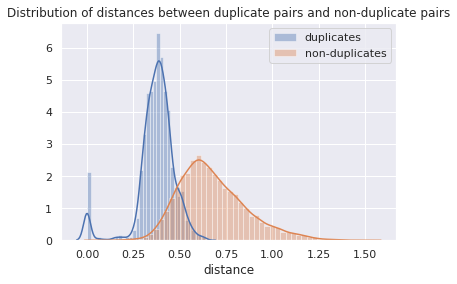

In [76]:
plt.figure()
plt.title('Distribution of distances between duplicate pairs and non-duplicate pairs')
sns.distplot(duplicate_distances, label='duplicates')
sns.distplot(non_duplicate_distances, label='non-duplicates')
plt.legend()
plt.xlabel('distance')
plt.show()

### Duplicates are more likely to have a small distance, but currenlty the embedding is crap

# TSNE visualization

In [77]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [78]:
tsne = TSNE(
    n_components=2,
    metric='cosine',
    n_jobs=3,
    verbose=True,
)

In [79]:
spec_features_ld = tsne.fit_transform(vecs)

In [80]:
spec_features_ld.shape

(29771, 2)

In [81]:
spec_features_ld = pd.DataFrame(spec_features_ld, index=specs_df.spec_id)
spec_features_ld['class_'] = classes_df.class_
spec_features_ld.shape

(29771, 3)

In [82]:
specs_df.iloc[46]

spec_id             www.ebay.com//41954
page_title         canon eos 20d 8 2 mp
page_title_stem     canon eo 20d 8 2 mp
brand                             canon
site                       www.ebay.com
Name: www.ebay.com//41954, dtype: object

In [83]:
spec_features_ld.iloc[46]

0          0.745274
1         41.142963
class_     6.000000
Name: www.ebay.com//41954, dtype: float64

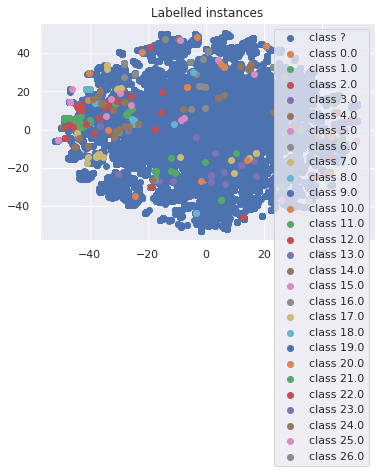

In [84]:
plt.figure()
plt.title('Labelled instances')
class_ld_df = spec_features_ld[pd.isnull(spec_features_ld.class_)]
plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class ?')

for class_ in spec_features_ld['class_'].sort_values().unique():
    if pd.isnull(class_):
        continue
    class_ld_df = spec_features_ld[spec_features_ld.class_==class_]
    plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class {class_}')

plt.legend()
plt.show()